In [66]:
from glob import glob
import os

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib import cm
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from shapely.geometry import box

# optional - turn off warnings
import warnings
warnings.filterwarnings('ignore')

In [37]:
## bring in sierra nevada range
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))
path = os.path.join("reg9_eco_l3", "reg9_eco_l3.shp")
eco_bound = gpd.read_file(path)
eco_bound[eco_bound['US_L3CODE']=='7']
sn = eco_bound[eco_bound['US_L3CODE']=='5']

os.chdir(os.path.join(et.io.HOME,'earth-analytics/'))

In [40]:
files = os.listdir('pedata')
f = os.path.join(os.getcwd(),'pedata',files[1])

<AxesSubplot:>

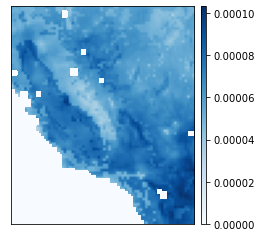

In [43]:
fig,ax=plt.subplots()
pe = rxr.open_rasterio(f,decode_times=False)
ep.plot_bands(tmp,ax=ax,cmap='Blues',vmin=0, vmax=np.nanmax(tmp.data))

In [53]:
sn_trans = sn.to_crs(pe.rio.crs)
sn_geom = sn.to_crs(pe.rio.crs)

from rasterio.plot import plotting_extent
#  Create a box representing the spatial extent of your data
crop_bound_box = [box(*sn.total_bounds)]
# Clip the data by  chaining together rio.clip with rio.open_rasterio
# from_disk=True allows you to only open the data that you wish to work with
pe_clip = pe.rio.clip(crop_bound_box, crs=sn.crs,
                                    # Include all pixels even partial pixels
                                    all_touched=True,
                                    from_disk=True).squeeze()


pe_ext = plotting_extent(pe_clip,
                            pe_clip.rio.transform())


<AxesSubplot:title={'center':'2016-09-09'}>

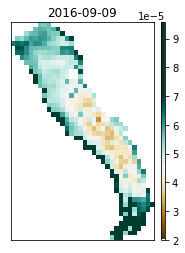

In [72]:
import matplotlib
cols = cm.get_cmap('BrBG', 256)
newcolors = cols(np.linspace(0, 1.5, 256))
white = np.array([1,1,1,0])
newcolors[:1, :] = white
newcmp = matplotlib.colors.ListedColormap(newcolors)

fig,ax=plt.subplots()
# Plotting Bounds Clip
maxval=np.nanmax(pe_clip.values)
pe_clip = pe.rio.clip(sn_geom.geometry,
                    all_touched=True,
                    from_disk=True)
ep.plot_bands(pe_clip,
            ax=ax,
            extent=pe_ext,
            cbar=True, 
            cmap = newcmp,
            title = '2016-09-09',
            vmin=2e-5, vmax=maxval)

In [71]:
f

'/Users/marianne/earth-analytics/pedata/NCALDAS_NOAH0125_D.A20160909.002.nc4.SUB.tif'

In [50]:
pe_ext

(-121.75, -117.625, 34.5, 40.75)